In [4]:
# 必要なライブラリのimport
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import os
import re
import glob
import shutil
from pathlib import Path

# matplotlibの日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
random_seed = 123

In [5]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

# 今回のコンペについて

## コンペの外観

* [Home Credit とは](https://www.homecredit.net/)：信用力が足りずに融資を受けることができない顧客にも融資を行う会社のことです。
* 目的：個人のクレジット情報や以前の応募情報などから、各データが債務不履行になるかどうかを予測する問題です。


* 評価方法：[AUC (Aread Under the ROC curve)](https://blog.kikagaku.co.jp/roc-auc)
  * 閾値を変化させた際に描かれるROC曲線の下の面積(=AUC)を0~1の範囲で判断し、1に近づくほど良いとされます。
  * つまり positive or negative, Yes or No みたいなのをきちんと分類されていれば良いとされます。



## 機械学習とは
機械学習とは、ざっと言ってしまうとあるデータ X を入力として対応する予測値 y を取り出すような対応関係を作成することです。

例：タイタニック号で、乗客が生きるか死ぬかを予測する問題だと X は乗客の年齢, 性別, 船室のグレード… など乗客に紐づく情報のことを指します。通常、この情報のことを特徴量とよびます。

特徴量 X と 予測値 y が用意できれば学習用データ (X - y の関係がわかっているデータ) を元にして X をいれて y になるようにモデルを調整する。この調整の段階を学習とよびます。学習には様々なアルゴリズムがあるが、X, y を用意しなくてはならない部分は基本的に変わらないです。

# データ管理環境整備
 
≒ディレクトリ整備


In [6]:
# # input_dir（input directory） を作ります
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# INPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) を作ります
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# OUTPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [7]:
# # csvファイルを `data` ディレクトリ（=フォルダー） に移動させます
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*.csv'):
#     unique_dir_names.append(f)

# for file in list(set(unique_dir_names)):
#     print(f'moved file: {file}')
#     shutil.move(f'{file}', f'{INPUT_DIR}')

In [8]:
# csv を読み取る関数を設定したあげると、pathや拡張子を書かずに読み込めるので入力が楽になります
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.csv')
    print(f'Load: {path}')
    return pd.read_csv(path, **kwrgs)

# データ読み込み

In [9]:
# application_train.csv
app_train = read_csv('application_train')
app_test = read_csv('application_test')
bureau_balance = read_csv('bureau_balance')
bureau = read_csv('bureau')
credit_balance = read_csv('credit_card_balance')
column_desc = read_csv('HomeCredit_columns_description')
instal_payment = read_csv('installments_payments')
pos_cash = read_csv('POS_CASH_balance')
prev_app = read_csv('previous_application')
samp_sub = read_csv('sample_submission')

Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/application_train.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/application_test.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/bureau_balance.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/bureau.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/credit_card_balance.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/HomeCredit_columns_description.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/installments_payments.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/POS_CASH_balance.csv
Load: /Users/satoshiido/Documents/coding_general/kaggle/home-credit-default-risk/data/previous_application.csv
Load: /Users/satoshiid

In [10]:
# 以下のカラムは頻出で、毎回入力するのはめんどくさいので、ポップアップされるように定義します
SK_ID_CURR = 'SK_ID_CURR'
SK_ID_PREV = 'SK_ID_PREV'
SK_ID_BUREAU = 'SK_ID_BUREAU'

## 各テーブルデータの概説

<b>application_{train|test}</b>

* 基本となるファイルです。顧客ごとに1つずつローンの情報とtrainにはデフォルトしたかという情報(Target)が含まれています。
* ER図で見ても分かる通り、`SK_ID_CURR` で `previous_appliation.csv` や `bureau.csv` と紐づけられます。
* application_testデータはtestデータとして使用されます。

>以下のテーブルデータをtrain_df, test_dfに正確に加えるためにはSK_ID_CURRごとにデータをまとめる必要があります

<b>bureau_balance</b>

* bureau.csvの毎月の残高データです。bureauと組み合わせて使います。

<b>bureau</b>

* 調査局のデータで、全ての顧客が過去に借りた他の金融機関からのローン情報となります。他の金融機関から Home Credit 社に情報提供されたものです。

<b>credit_card_balance</b>

* Home Credit 社のもつ申請者の月次クレジットカード残高のスナップショットになります。

<b>installments_payments</b>

* サンプルローンに関連する Home Credit 社にある過去実績になります。

<b>POS_CASH_balance</b>

* Home Credit 社のもつ申請者の月次クレジットカード残高を販売拠点ごとにまとめたものです。

<b>previous_application</b>

* 申請者の Home Credit 社でのローン履歴となります。

<b>sample_submission</b>

* サンプルcsvです。



# データ確認

各データのサイズを見てみます

## application_{train|test}

app_train, app_testを例に見てみると、
* 各ユーザーで1行
* app_testには `TARGET` が抜けているとわかる
* 欠損値が散見される
* カテゴリ関数がある
* 日付が時間差表記されている
* カラム多すぎるし、何なのかわからん (* ただありがたいことに `HomeCredit_columns_description.csv` で説明がされている)

In [11]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0000,-2120,NaN,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,Cash loans,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188,-1186.0000,-291,NaN,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6222,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.5559,0.

In [12]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0000,568800.0000,20560.5000,450000.0000,Unaccompanied,Working,Higher education,Married,House / apartment,0.0188,-19241,-2329,-5170.0000,-812,NaN,1,1,0,1,0,1,NaN,2.0000,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.7526,0.7897,0.1595,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0000,0.0000,0.0000,0.0000,-1740.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,100005,Cash loans,M,N,Y,0,99000.0000,222768.0000,17370.0000,180000.0000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.0358,-18064,-4469,-9118.0000,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0000,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.5650,0.2917,0.4330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
2,100013,Cash loans,M,Y,Y,0,202500.0000,663264.0000,69777.0000,630000.0000,NaN,Working,Higher education,Married,House / apartment,0.0191,-20038,-4458,-2175.0000,-3503,5.0000,1,1,0,1,0,0,Drivers,2.0000,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.6998,0.6110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,-856.0000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,1

In [13]:
# データの統計量
display(app_train.describe())

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307499.0000,307233.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,104582.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307509.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,134133.0000,306851.0000,246546.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,159080.0000,306490.0000,306490.0000,306490.0000,306490.0000,307510.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,265992.0000,265992.0000,265992.0000,265992.0000,265992.0000,265992.0000
mean,278180.5186,0.0807,0.4171,168797.9193,599025.9997,27108.5739,538396.2074,0.0209,-16036.9951,63815.0459,-4986.1203,-2994.2024,12.0611,1.0000,0.8199,0.1994,0.9981,0.2811,0.0567,2.1527,2.0525,2.0315,12.0634,0.0151,0.0508,0.0407,0.0782,0.2305,0.1796,0.5021,0.5144,0.5109,0.1174,0.0884,0.9777,0.7525,0.0446,0.0789,0.1497,0.2263,0.2319,0.0663,0.1008,0.1074,0.0088,0.0284,0.1142,0.0875,0.9771,0.7596,0.0426,0.0745,0.1452,0.2223,0.2281,0.0650,0.1056,0.1060,0.0081,0.0270,0.1178,0.0880,0.9778,0.7557,0.0446,0.0781,0.1492,0.2259,0.2316,0.0672,0.1020,0.1086,0.0087,0.0282,0.1025,1.4222,0.1434,1.4053,0.1000,-962.8588,0.0000,0.7100,0.0001,0.0151,0.0881,0.0002,0.0814,0.0039,0.0000,0.0039,0.0000,0.0035,0.0029,0.0012,0.0099,0.0003,0.0081,0.0006,0.0005,0.0003,0.0064,0.0070,0.0344,0.2674,0.2655,1.9000
std,102790.1753,0.2724,

In [14]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

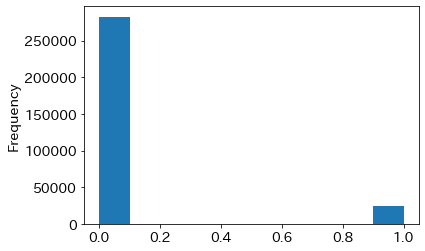

In [15]:
# Positiveのケースが少ない。極端に少ないわけではないので一旦見逃す
app_train['TARGET'].astype(int).plot.hist();

In [16]:
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('正の相関関係があるTOP15:\n', correlations.tail(15))
print('\n負の相関関係があるTOP15:\n', correlations.head(15))

正の相関関係があるTOP15:
 DEF_60_CNT_SOCIAL_CIRCLE      0.0313
DEF_30_CNT_SOCIAL_CIRCLE      0.0322
LIVE_CITY_NOT_WORK_CITY       0.0325
OWN_CAR_AGE                   0.0376
DAYS_REGISTRATION             0.0420
FLAG_DOCUMENT_3               0.0443
REG_CITY_NOT_LIVE_CITY        0.0444
FLAG_EMP_PHONE                0.0460
REG_CITY_NOT_WORK_CITY        0.0510
DAYS_ID_PUBLISH               0.0515
DAYS_LAST_PHONE_CHANGE        0.0552
REGION_RATING_CLIENT          0.0589
REGION_RATING_CLIENT_W_CITY   0.0609
DAYS_BIRTH                    0.0782
TARGET                        1.0000
Name: TARGET, dtype: float64

負の相関関係があるTOP15:
 EXT_SOURCE_3                 -0.1789
EXT_SOURCE_2                 -0.1605
EXT_SOURCE_1                 -0.1553
DAYS_EMPLOYED                -0.0449
FLOORSMAX_AVG                -0.0440
FLOORSMAX_MEDI               -0.0438
FLOORSMAX_MODE               -0.0432
AMT_GOODS_PRICE              -0.0396
REGION_POPULATION_RELATIVE   -0.0372
ELEVATORS_AVG                -0.0342
ELEVATORS_M

## bureau

In [17]:
# bureauも見てみる
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0000,-153.0000,NaN,0,91323.0000,0.0000,NaN,0.0000,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0000,NaN,NaN,0,225000.0000,171342.0000,NaN,0.0000,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0000,NaN,NaN,0,464323.5000,NaN,NaN,0.0000,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0000,NaN,NaN,0.0000,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0000,NaN,77674.5000,0,2700000.0000,NaN,NaN,0.0000,Consumer credit,-21,NaN


In [18]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## credit_card_balance

In [19]:
credit_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.9700,135000,0.0000,877.5000,0.0000,877.5000,1700.3250,1800.0000,1800.0000,0.0000,0.0000,0.0000,0.0000,1,0.0000,1.0000,35.0000,Active,0,0
1,2582071,363914,-1,63975.5550,45000,2250.0000,2250.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,60175.0800,64875.5550,64875.5550,1.0000,1,0.0000,0.0000,69.0000,Active,0,0
2,1740877,371185,-7,31815.2250,450000,0.0000,0.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,26926.4250,31460.0850,31460.0850,0.0000,0,0.0000,0.0000,30.0000,Active,0,0
3,1389973,337855,-4,236572.1100,225000,2250.0000,2250.0000,0.0000,0.0000,11795.7600,11925.0000,11925.0000,224949.2850,233048.9700,233048.9700,1.0000,1,0.0000,0.0000,10.0000,Active,0,0
4,1891521,126868,-1,453919.4550,450000,0.0000,11547.0000,0.0000,11547.0000,22924.8900,27000.0000,27000.0000,443044.3950,453919.4550,453919.4550,0.0000,1,0.0000,1.0000,101.0000,Active,0,0


In [20]:
credit_balance['NAME_CONTRACT_STATUS'].unique()

array(['Active', 'Completed', 'Demand', 'Signed', 'Sent proposal',
       'Refused', 'Approved'], dtype=object)

In [21]:
credit_balance['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

## previous_application

In [22]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.4300,17145.0000,17145.0000,0.0000,17145.0000,SATURDAY,15,Y,1,0.0000,0.1828,0.8673,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0000,middle,POS mobile with interest,365243.0000,-42.0000,300.0000,-42.0000,-37.0000,0.0000
1,2802425,108129,Cash loans,25188.6150,607500.0000,679671.0000,NaN,607500.0000,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0000,low_action,Cash X-Sell: low,365243.0000,-134.0000,916.0000,365243.0000,365243.0000,1.0000
2,2523466,122040,Cash loans,15060.7350,112500.0000,136444.5000,NaN,112500.0000,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,high,Cash X-Sell: high,365243.0000,-271.0000,59.0000,365243.0000,365243.0000,1.0000
3,2819243,176158,Cash loans,47041.3350,450000.0000,470790.0000,NaN,450000.0000,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,middle,Cash X-Sell: middle,365243.0000,-482.0000,-152.0000,-182.0000,-177.0000,1.0000
4,1784265,202054,Cash loans,31924.3950,337500.0000,404055.0000,NaN,337500.0000,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
prev_app['NAME_CONTRACT_TYPE'].unique()

array(['Consumer loans', 'Cash loans', 'Revolving loans', 'XNA'],
      dtype=object)

In [24]:
prev_app['NFLAG_LAST_APPL_IN_DAY'].unique()

array([1, 0])

In [25]:
prev_app['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

In [26]:
prev_app['NAME_CONTRACT_STATUS'].unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

In [27]:
prev_app['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [28]:
prev_app['NAME_CASH_LOAN_PURPOSE'].unique()

array(['XAP', 'XNA', 'Repairs', 'Everyday expenses', 'Car repairs',
       'Building a house or an annex', 'Other', 'Journey',
       'Purchase of electronic equipment', 'Medicine',
       'Payments on other loans', 'Urgent needs', 'Buying a used car',
       'Buying a new car', 'Buying a holiday home / land', 'Education',
       'Buying a home', 'Furniture', 'Buying a garage',
       'Business development', 'Wedding / gift / holiday', 'Hobby',
       'Gasification / water supply', 'Refusal to name the goal',
       'Money for a third person'], dtype=object)

In [29]:
prev_app['NAME_CASH_LOAN_PURPOSE'].value_counts()

XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                                   55
Money for a

## instalments_payments

In [30]:
instal_payment.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0000,6,-1180.0000,-1187.0000,6948.3600,6948.3600
1,1330831,151639,0.0000,34,-2156.0000,-2156.0000,1716.5250,1716.5250
2,2085231,193053,2.0000,1,-63.0000,-63.0000,25425.0000,25425.0000
3,2452527,199697,1.0000,3,-2418.0000,-2426.0000,24350.1300,24350.1300
4,2714724,167756,1.0000,2,-1383.0000,-1366.0000,2165.0400,2160.5850


## POS_CASH_balance

In [31]:
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0000,45.0000,Active,0,0
1,1715348,367990,-33,36.0000,35.0000,Active,0,0
2,1784872,397406,-32,12.0000,9.0000,Active,0,0
3,1903291,269225,-35,48.0000,42.0000,Active,0,0
4,2341044,334279,-35,36.0000,35.0000,Active,0,0


## 欠損値状況

欠損値状況を見てみると、かなり欠損値が多いカラムがあることが伺えます

In [32]:
# 欠損値の確認関数
def missing_values_summary(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'mis_val_count', 1 : 'mis_val_percent'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('mis_val_percent', ascending=False).round(1)
    print ("カラム数：" + str(df.shape[1]) + "\n" + "欠損値のカラム数： " + str(mis_val_table_ren_columns.shape[0]))
    return mis_val_table_ren_columns

In [33]:
missing_values_summary(app_train)

カラム数：122
欠損値のカラム数： 67


,mis_val_count,mis_val_percent
COMMONAREA_MEDI,214865,69.9000
COMMONAREA_AVG,214865,69.9000
COMMONAREA_MODE,214865,69.9000
NONLIVINGAPARTMENTS_MEDI,213514,69.4000
NONLIVINGAPARTMENTS_MODE,213514,69.4000
...,...,...
EXT_SOURCE_2,660,0.2000
AMT_GOODS_PRICE,278,0.1000
AMT_ANNUITY,12,0.0000
CNT_FAM_MEMBERS,2,0.0000


In [34]:
missing_values_summary(bureau)

カラム数：17
欠損値のカラム数： 7


,mis_val_count,mis_val_percent
AMT_ANNUITY,1226791,71.5000
AMT_CREDIT_MAX_OVERDUE,1124488,65.5000
DAYS_ENDDATE_FACT,633653,36.9000
AMT_CREDIT_SUM_LIMIT,591780,34.5000
AMT_CREDIT_SUM_DEBT,257669,15.0000
DAYS_CREDIT_ENDDATE,105553,6.1000
AMT_CREDIT_SUM,13,0.0000


In [35]:
# previous applicationの欠損値も見てみます
missing_values_summary(prev_app)

カラム数：37
欠損値のカラム数： 16


,mis_val_count,mis_val_percent
RATE_INTEREST_PRIMARY,1664263,99.6000
RATE_INTEREST_PRIVILEGED,1664263,99.6000
AMT_DOWN_PAYMENT,895844,53.6000
RATE_DOWN_PAYMENT,895844,53.6000
NAME_TYPE_SUITE,820405,49.1000
DAYS_FIRST_DRAWING,673065,40.3000
DAYS_FIRST_DUE,673065,40.3000
DAYS_LAST_DUE_1ST_VERSION,673065,40.3000
DAYS_LAST_DUE,673065,40.3000
DAYS_TERMINATION,673065,40.3000


## スキーマ（構造）の理解

各データのサイズを見てみます

In [36]:
# サイズ
print(f'Size of application_train: {app_train.shape}')
print('>Unique counts of current loan ID:', app_train[SK_ID_CURR].nunique())
print(f'Size of application_test: {app_test.shape}')
print('>Unique counts of current loan ID:', app_test[SK_ID_CURR].nunique())
print('--------')
print(f'Size of bureau_balance: {bureau_balance.shape}')
print('>Unique counts of bureau ID:', bureau_balance[SK_ID_BUREAU].nunique())
print(f'Size of bureau: {bureau.shape}')
print('>Unique counts of bureau ID:', bureau[SK_ID_BUREAU].nunique())
print('--------')
print(f'Size of previous_application: {prev_app.shape}')
print('>Unique counts of current loan ID:', prev_app[SK_ID_CURR].nunique())
print('>Unique counts of previous loan ID:', prev_app[SK_ID_PREV].nunique())
print('--------')
print(f'Size of credit_card_balance: {credit_balance.shape}')
print('>Unique counts of current loan ID:', prev_app[SK_ID_CURR].nunique())
print('>Unique counts of previous loan ID:', prev_app[SK_ID_PREV].nunique())
print('--------')
print(f'Size of installments_payments: {instal_payment.shape}')
print('>Unique counts of current loan ID:', instal_payment[SK_ID_CURR].nunique())
print('>Unique counts of previous loan ID:', instal_payment[SK_ID_PREV].nunique())
print('--------')
print(f'Size of POS_CASH_balance: {pos_cash.shape}')
print('>Unique counts of current loan ID:', pos_cash[SK_ID_CURR].nunique())
print('>Unique counts of previous loan ID:', pos_cash[SK_ID_PREV].nunique())
print('--------')
# サブミットするサンプルcsv
print(f'Size of sample_submission: {samp_sub.shape}')


Size of application_train: (307511, 122)
>Unique counts of current loan ID: 307511
Size of application_test: (48744, 121)
>Unique counts of current loan ID: 48744
--------
Size of bureau_balance: (27299925, 3)
>Unique counts of bureau ID: 817395
Size of bureau: (1716428, 17)
>Unique counts of bureau ID: 1716428
--------
Size of previous_application: (1670214, 37)
>Unique counts of current loan ID: 338857
>Unique counts of previous loan ID: 1670214
--------
Size of credit_card_balance: (3840312, 23)
>Unique counts of current loan ID: 338857
>Unique counts of previous loan ID: 1670214
--------
Size of installments_payments: (13605401, 8)
>Unique counts of current loan ID: 339587
>Unique counts of previous loan ID: 997752
--------
Size of POS_CASH_balance: (10001358, 8)
>Unique counts of current loan ID: 337252
>Unique counts of previous loan ID: 936325
--------
Size of sample_submission: (48744, 2)


In [37]:
# データフレームの特徴を自動的に作ってくれる pandas-profiling を利用する方法もある\
# しかしカラム数が多すぎると、ファイルサイズが大きくなり、表示失敗しやすくなるため注意

app_columns = app_train.columns
display(len(app_columns))
display(len(app_train))

122

307511

In [38]:
# https://qiita.com/wakame1367/items/39faf5d91e20a5cf5772#_reference-a12e589891bdd7bf36e5
from pandas_profiling import ProfileReport

report1 = ProfileReport(app_train[app_columns[1:9]], missing_diagrams={
    'bar': False,
    'matrix': False,
    'heatmap': False,
    'dendrogram': False})

report1.to_file(os.path.join(OUTPUT_DIR, "report_of_application_train_first_half.html"))
# カラム数が多いせいか、htmlファイルのロードで失敗することがあるので、dataframe を半分にします
# app_train_first_half = app_train.iloc[:, :60]
# app_train_second_half = app_train.iloc[:, 60:]
# app_train_second_half = pd.concat([app_train.iloc[:, :2], app_train_second_half], axis=1)

# 分割したカラムそれぞれでレポートを作成します
# report1 = ProfileReport(app_train_first_half)
# report1.to_file(os.path.join(OUTPUT_DIR, "report_of_application_train_first_half.html"))
# report2 = ProfileReport(app_train_second_half)
# report2.to_file(os.path.join(OUTPUT_DIR, "report_of_application_train_second_half.html"))

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
Summarize dataset:  58%|█████▊    | 11/19 [00:01<00:00,  8.33it/s, Calculate kendall correlation]      /Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 574.64it/s]


## 学習データ(=入力データ & 正解データ)の作成

ある程度データを理解したところで学習データを作っていきましょう

* 基本方針として、`app_train` でとりあえず使えそうなカラムと、その他のテーブルデータの基本統計量をマージして使用します
* Light GBMといったGBDT系のモデルを使用します
* 欠損値は一旦そのままにします
* カテゴリデータはラベルエンコーディングします

In [39]:
credit_balance.groupby([SK_ID_CURR], as_index=False).mean()

,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
0,100006,1489396.0000,-3.5000,0.0000,270000.0000,NaN,0.0000,NaN,NaN,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,NaN,NaN,0.0000,0.0000,0.0000
1,100011,1843384.0000,-38.5000,54482.1111,164189.1892,2432.4324,2432.4324,0.0000,0.0000,3956.2218,4843.0642,4520.0676,52402.0889,54433.1791,54433.1791,0.0541,0.0541,0.0000,0.0000,25.7671,0.0000,0.0000
2,100013,2038692.0000,-48.5000,18159.9192,131718.7500,6350.0000,5953.1250,0.0000,0.0000,1454.5396,7168.3462,6817.1723,17255.5598,18101.0798,18101.0798,0.2556,0.2396,0.0000,0.0000,18.7191,0.0104,0.0104
3,100021,2594025.0000,-10.0000,0.0000,675000.0000,NaN,0.0000,NaN,NaN,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,NaN,NaN,0.0000,0.0000,0.0000
4,100023,1499902.0000,-7.5000,0.0000,135000.0000,NaN,0.0000,NaN,NaN,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,NaN,NaN,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,2181926.0000,-21.0000,131834.7307,296341.4634,24475.6098,26842.3880,0.0000,2363.0159,6514.2000,32720.5449,32720.5449,127608.3735,130767.0607,130767.0607,1.0488,1.3659,0.0000,0.3171,13.6000,0.0000,0.0000
103554,456246,1079732.0000,-5.5000,13136.7319,135000.0000,0.0000,15199.2563,0.0000,15199.2563,1439.1506,18778.2750,15554.3400,12883.0163,12897.8944,12897.8944,0.0000,2.5000,0.0000,2.5000,3.5000,0.0000,0.0000
103555,456247,1595171.0000,-49.0000,23216.3962,144000.0000,2136.3158,2149.5065,0.0000,13.1907,1414.7048,4883.7553,4115.8781,22100.6539,23128.2431,23128.2431,0.1158,0.1474,0.0000,0.0316,26.4947,0.0316,0.0211
103556,456248,2743495.0000,-13.0000,0.0000,900000.0000,NaN,0.0000,NaN,NaN,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,NaN,NaN,0.0000,0.0000,0.0000


In [40]:
# 各ｄｆの基本統計量のうち、一旦平均値を取って集計する -> SK_ID_CURRでユニークな値が生まれた
cd_b = credit_balance.groupby([SK_ID_CURR], as_index=False).mean()
ins_p = instal_payment.groupby([SK_ID_CURR], as_index=False).mean()
pos_c = pos_cash.groupby([SK_ID_CURR], as_index=False).mean()
prv_a = prev_app.groupby([SK_ID_CURR], as_index=False).mean()

# SK_ID_PREV は不要なため削除する
cd_b = cd_b.drop(SK_ID_PREV, axis=1)
ins_p = ins_p.drop(SK_ID_PREV, axis=1)
pos_c = pos_c.drop(SK_ID_PREV, axis=1)
prv_a = prv_a.drop(SK_ID_PREV, axis=1)

# カラム名が重複しないように名称を変更する
cd_b2 = cd_b.rename(columns={'MONTHS_BALANCE':'MONTHS_BALANCE_CREDIT', 'SK_DPD' : 'SK_DPD_CRE_CREDIT', 'SK_DPD_DEF' : 'SK_DPD_DEF_CREDIT'})
prv_a2 = prv_a.rename(columns={'AMT_CREDIT':'AMT_CREDIT_PRE_APP', 'AMT_ANNUITY' : 'AMT_ANNUITY_PRE_APP', 'AMT_GOODS_PRICE' : 'AMT_GOODS_PRICE_PRE_APP'})


前処理（カテゴリ変数の変換）

カテゴリデータは基本的にそのまま特徴量として扱えないので、数値化する必要があります。\
カテゴリ変数の変換にはいくつもの手法がありますが、よくやるものでもデータや使うモデルによって向き不向きがあるので気をつけましょう。

* One-Hot Encoding -> gbdt系以外（線形モデル etc..）におすすめ
* Label Encoding-> gbdt系 にもおすすめ\
[【sklearn】LabelEncoderの使い方を丁寧に](https://gotutiyan.hatenablog.com/entry/2020/09/08/122621)
* Target Encoding -> gbdt系にはより効果的らしい\
[Target Encoding はなぜ有効なのか](https://speakerdeck.com/hakubishin3/target-encoding-hanazeyou-xiao-nafalseka)

In [41]:
# LabelEncoder()は，文字列や数値で表されたラベルを，0~(ラベル種類数-1)までの数値に変換してくれるものです
from sklearn.preprocessing import LabelEncoder

tmp_app_train = app_train.copy()
tmp_app_test = app_test.copy()

# 今回はtmp_app_{train|test}、bureau、の中にあるカテゴリカラムをラベルエンコーディングします
## tmp_app_{tain|test}
le_cols_app = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
## bureau (*Active, Closedは後で利用するので取っておく)
le_cols_bureau = ['CREDIT_CURRENCY', 'CREDIT_TYPE']
## credit_balance
le_cols_credit_balance = ['NAME_CONTRACT_STATUS']
## previous_application
le_cols_prev_app = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', ]

for c in le_cols_app:
    # LabelEncoderを宣言します
    le = LabelEncoder()
    # ラベルとラベルIDの対応づけを行います。positiveは0にしよう，みたいなことを決めます
    le.fit(tmp_app_train[c].fillna('NA'))

    # 学習データとテストデータそれぞれのdf内のカラムを変換します
    tmp_app_train[c] = le.transform(tmp_app_train[c].fillna('NA'))
    tmp_app_test[c] = le.transform(tmp_app_test[c].fillna('NA'))

In [42]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0000,-2120,NaN,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,Cash loans,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188,-1186.0000,-291,NaN,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6222,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.5559,0.

In [43]:
# app_trainと比べて、`Target` カラムがなくなっていることがわかると思います
tmp_app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0000,406597.5000,24700.5000,351000.0000,7,7,4,3,1,0.0188,-9461,-637,-3648.0000,-2120,NaN,1,1,0,1,1,0,8,1.0000,2,2,6,10,0,0,0,0,0,0,5,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,3,1,0.0149,6,1,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,0,0,0,0,0,270000.0000,1293502.5000,35698.5000,1129500.0000,1,4,1,1,1,0.0035,-16765,-1188,-1186.0000,-291,NaN,1,1,0,1,1,0,3,2.0000,1,1,1,11,0,0,0,0,0,0,39,0.3113,0.6222,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,3,1,0.0714,0,1,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,1,1,1,1,0,67500.0000,135000.0000,6750.0000,135000.0000,7,7,4,3,1,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,8,1.0000,2,2,1,9,0,0,0,0,0,0,11,NaN,0.5559,0.7296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,3,0,0.0000,0.0000,0.0000,0.0000,-815.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,100006,0,0,0,0,1,0,135000.0000,312682.5000,29686.5000,297000.0000,7,7,4,0,1,0.0080,-19005,

テーブルデータをマージします

In [44]:
#　マージ
## `instalments_payments` に `credit_card_balance` テーブルをマージします
tmp1 = pd.merge(ins_p, cd_b2, on=SK_ID_CURR, how='left')
## `tmp1` に `pos_c` テーブルをマージします
tmp2 = pd.merge(tmp1, pos_c, on=SK_ID_CURR, how='left')
## `tmp2` に `previous_application` テーブルをマージします
tmp3 = pd.merge(tmp2, prv_a2, on=SK_ID_CURR, how='left')

## train と test にもマージします
### 今回は app_{train|test} のカラムの削除を敢えてせずに全て使用します。
train = pd.merge(tmp_app_train, tmp3, on=SK_ID_CURR, how='left')
test = pd.merge(tmp_app_test, tmp3, on=SK_ID_CURR, how='left')

予測対象となる `TARGET`カラムを抜き出し、 `y` とします

同時にtrainから `TARGET`カラムを削除します

In [45]:
y_train = train['TARGET']

X_train = train.drop('TARGET', axis=1)

X_test = test.copy()

In [46]:
# numpy 配列に直します
X, y = X_train.values, y_train.values
X_test2 = X_test.values

In [47]:
# X_trainとy_trainの行数が、X_train, X_testのカラム数がそれぞれ同数なのでOK
print(X.shape, y.shape, X_test2.shape)

(307511, 171) (307511,) (48744, 171)


# 簡単に学習・予測・サブミットまでしてみる

## 学習

特徴量を作成できたので次にモデルの学習を行っていきます。この時大事になるのが交差検証 (Cross Validation) という考え方です。

* Cross Validation とは\
Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

* なんで Cross Validation するの?\
なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうので良くないです。

>仕事的な観点で言ってもLBに出すというのはデプロイ(本番へ反映すること)だから、本番に出さないとモデルの良し悪しがわからないのはよろしくないのと一緒

一番ナイーブな戦略は Random と呼ばれるものです。これは何も考えずにとにかくランダムに学習データを分割します。

その他にターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。

あとは「各分割で特定のグループが重ならないようにする」Group もよく使われます。

その他にも時系列で区切る TimeSeriesSplit という方法もあります。

### どの分割方法がいいの?
どの分割方法が一番良いのかは一概に言えません。

まず良い分割とはなにかを考えてみると、良い分割とは今のモデルがテストデータでどのぐらいの性能を出すかを、検証データで確認できる分割だと考えられます。

つまり、分割された学習/検証用データが、全体の学習/テストデータとの対応関係と一致していることといえます。
したがって本来、分割を決める際には学習データとテストデータの関係性をしらべ、それと同じ分割を採用する必要があります。

In [48]:
# 今回は王道の Stratified K Fold (層化抽出)を利用します
## stratified K Foldはテストデータに含まれる各クラスの割合は、学習データに含まれる各クラスの割合とほぼ同じであろうという仮説に基づき、バリデーションの評価を安定させようとする手法です。
## 多クラス分類のような極端に頻度の少ないクラスがある場合は、層化抽出を行うのが重要です。ただ今回のような二値分類で偏りが大きくない場合はあまり効用を感じないかもしれないです。
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=510)
cv = fold.split(X, y)
# split の返り値は generator だから、list 化して何度も iterate できるようにしておく
cv = list(cv)

## モデル構築

今回はlightgbmを使用します。\
GBDT(Gradient Boosting Decision Tree: 勾配ブースティング木)と呼ばれる決定技をベースとしたアルゴリズムの一種でテーブルデータで性能が高いことが知られています。

### LightGBM による CrossValidation を用いた学習
今回は使う機械学習モデルとして lightGBM を使います

lightgbmの特徴として
* 数値の大きさ自体に意味がなく、大小関係のみが影響する
* 欠損値が存在している場合にも自然に取り扱えるため特に処理が必要ない
* 決定技の分岐の繰り返しによって、変数間の相互作用を反映する
* 特徴重要度(`feature importance`)をさっと確認できる
* CPU 環境でも高速に学習・推論が行える

ほかにも理由はありますが u++ さんの [「初手LightGBM」をする7つの理由](https://upura.hatenablog.com/entry/2019/10/29/184617) などが参考になります

こちらも参考に\
[LightGBMで交差検証を実装してみるよ](https://potesara-tips.com/lightgbm-k-fold-cross-validation/)

In [49]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

def fit_lgbm(X, y, 
                cv, 
                params: dict=None, 
                verbose: int=50):

    """lightGBM を CrossValidation の枠組みで学習を行うための関数を定義します"""

    # パラメータがない時は、空の dict で置き換える
    if params is None:
        params = {}
    
    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # この部分が交差検証のところ。データセットを `cv instance` によって分割します
        # training data を train/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix='fit fold={}'.format(i)):
            clf.fit(x_train,
                    y_train,
                    eval_set = [(x_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=verbose)
        
        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        # 今回の指標の `roc_auc_score` で計算する
        score = roc_auc_score(y_valid, pred_i)
        print(f'{score:.4f}')

    score = roc_auc_score(y, oof_pred)
    print(f'{score:.4f}')
    
    return oof_pred, models

### parameter について
LightGBM などの GBDT のパラメータは、そこまでセンシティブではないです。しかし、内部的にどういう意味を持つのかを知っておくと、問題ごとにどういうパラメータが良いかの感覚がわかったり、チューニングする際にも有効なパラメータに絞ってチューニングできるので、重要な変数に関してはその意味についてざっと目を通しておくことと良いと言われています。

参考文献。

[LightGBM 徹底入門 – LightGBMの使い方や仕組み、XGBoostとの違いについて](https://www.codexa.net/lightgbm-beginner/)\
[Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド。英語。\
[勾配ブースティングで大事なパラメータの気持ち](https://bit.ly/3L2xmcN): gotoさんが書いた記事。日本語。

In [50]:
lgbm_params = {
    # 目的関数、これの意味で最小となるようなパラメータを探します
    'objective': 'binary',

    # 学習率, 小さいほど滑らかな決定境界が作られて性能向上につながる場合が多いです
    # 一方でそれだけ木をつくるため、学習に時間がかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': .1,

    # L1
    'reg_alpha': 0,

    # 木の深さ、深い木を許容するほどより複雑な交互作用を考慮することになります
    'max_depth': 5,

    # 木の最大数, early_stopping という枠組みで木の数は制御されるようにしているので、とても大きい値を指定しておきます
    'n_estimators': 10000,

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます 
    # 小さくすることで満遍なく特徴を使うという効果があるそうです
    'colsample_samples': 10,

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック
    'importance_type': 'gain',
    'random_state': 71,

}

## モデル評価

モデルを実行し、結果を見てみます。\
Cross Validationしたスコアの平均は最後に表示されており、訓練データで `0.758` でした。\
lightgbmを使うと、それなりのスコアを出せることがわかります。\
サブミットしていないのでかなり安直ですが、メダル圏内まであと `0.03` ほど必要なので、まだまだ改善の余地があります。

In [51]:
oof, models =fit_lgbm(X=X, y=y, cv=cv, params=lgbm_params)

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.244933
[100]	valid_0's binary_logloss: 0.242505
[150]	valid_0's binary_logloss: 0.24194
[200]	valid_0's binary_logloss: 0.24185
[250]	valid_0's binary_logloss: 0.241858
[300]	valid_0's binary_logloss: 0.241805
fit fold=0 7.408[s]
0.7737


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.245838
[100]	valid_0's binary_logloss: 0.243678
[150]	valid_0's binary_logloss: 0.243083
[200]	valid_0's binary_logloss: 0.242888
[250]	valid_0's binary_logloss: 0.242829
[300]	valid_0's binary_logloss: 0.242901
fit fold=1 7.271[s]
0.7695


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.246261
[100]	valid_0's binary_logloss: 0.243432
[150]	valid_0's binary_logloss: 0.242702
[200]	valid_0's binary_logloss: 0.242542
[250]	valid_0's binary_logloss: 0.242417
[300]	valid_0's binary_logloss: 0.242468
[350]	valid_0's binary_logloss: 0.242429
[400]	valid_0's binary_logloss: 0.242655
fit fold=2 9.079[s]
0.7721


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.244901
[100]	valid_0's binary_logloss: 0.242233
[150]	valid_0's binary_logloss: 0.241431
[200]	valid_0's binary_logloss: 0.240992
[250]	valid_0's binary_logloss: 0.240856
[300]	valid_0's binary_logloss: 0.240851
[350]	valid_0's binary_logloss: 0.240916
fit fold=3 7.901[s]
0.7742


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.245527
[100]	valid_0's binary_logloss: 0.242838
[150]	valid_0's binary_logloss: 0.242257
[200]	valid_0's binary_logloss: 0.242033
[250]	valid_0's binary_logloss: 0.242007
[300]	valid_0's binary_logloss: 0.242015
[350]	valid_0's binary_logloss: 0.242135
fit fold=4 8.108[s]
0.7740
0.7727


### 特徴重要度（feature importance） の確認

In [52]:
def visualize_importance(models, X_train):
    """lightGBM の model 配列の feature_importance を plot する関数です
    CVごとのブレを boxen plot として表現します

    args:
        models:
            List of lightGBM models
        X_train:
            学習時に使った DataFrame
    """

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = X_train.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df],
            axis=0,
            ignore_index=True
        )
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                  )

    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

以下のコードで重要度が可視化できます。\
feature_importance は値が大きいほど有効な分割であることを意味します。\
しかし、想定とは異なる部分が重要となっています（EXT_SOURCE_#ってなんや！？）\
てきとーにカラムを選択すると特徴重要度を見たときに有用な示唆を得にくくなる例ですね汗\
カラムを取捨選択したり、掛け合わせて作成したり、自分なりの仮説を持って特徴量生成をした後に再度可視化をするとまた面白い示唆を得られるかもしれないです。

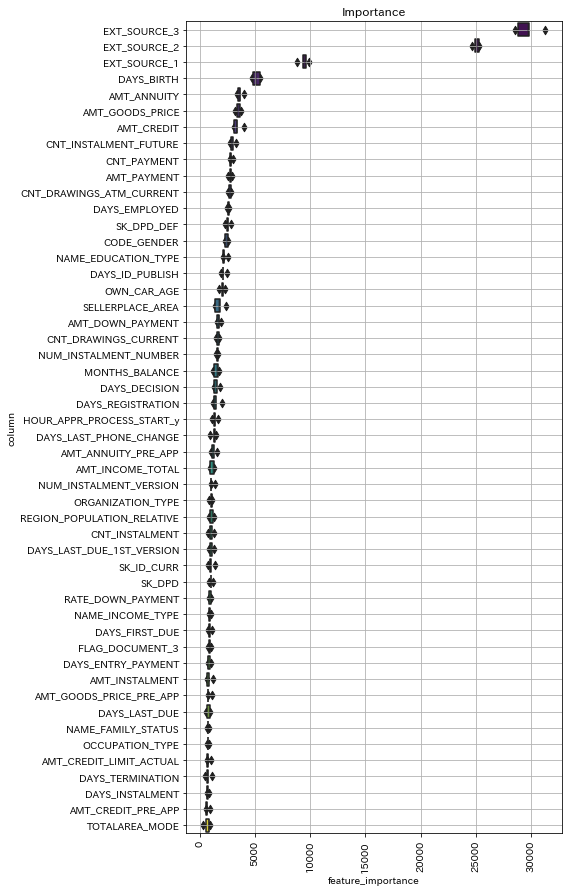

In [53]:
%matplotlib inline
fig, ax = visualize_importance(models, X_train)

In [54]:
models

[LGBMClassifier(colsample_samples=10, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_samples=10, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_samples=10, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_lambda=0.1, subsample=0.9,
                subsample_freq=3),
 LGBMClassifier(colsample_samples=10, importance_type='gain', max_depth=5,
                min_child_samples=10, n_estimators=10000, objective='binary',
                random_state=71, reg_alpha=0, reg_la

### 訓練データとテストデータでの予測結果の傾向差を見る
テストデータではどのような予測結果が出されるのか可視化してみます。\
今回のデータは訓練データとテストデータでユーザー特性が大きく異なることはあまりないと考えられます。\
なので訓練データとテストデータをもとにした予測結果もある程度は近くなると予測されます。

In [55]:
# K 個のモデルの予測確率（predict_proba） を作成します。 shape = (k, N_test, n_classes) になるはずです。
pred_prob = np.array([model.predict_proba(X_test2) for model in models])
print(f"1. shape: {pred_prob.shape}")

# k 個のモデルの平均を計算
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れます
print(f"2. shape: {pred_prob.shape}")


# 欲しいのは y=1 の確率なので全要素の 1 次元目を取ってきます
pred_prob = pred_prob[:, 1]
print(f'3. shape: {pred_prob.shape}')

# ついでにsample_submissionのshapeとも比較しましょう
print('4. shape:', samp_sub.shape)

1. shape: (5, 48744, 2)
2. shape: (48744, 2)
3. shape: (48744,)
4. shape: (48744, 2)


In [56]:
pred_prob

array([0.0416, 0.1028, 0.0205, ..., 0.0233, 0.0518, 0.2169])

どういったラベルが予測されているか、などの傾向を知っておきましょう。\
また学習時とテスト時で出力の乖離が無いか、を見ることも大事です。乖離が大きい場合には、入力する値自体が大きく異なっているなどで性能悪化が起こっている可能性があるのでサブミットする前に注意です。

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


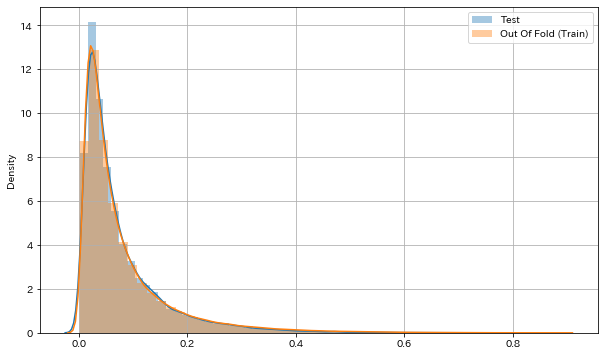

In [57]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(pred_prob, ax=ax, label="Test")
sns.distplot(oof, ax=ax, label="Out Of Fold (Train)")

ax.legend()
ax.grid()

#### NOTE: テストでの乖離が大きい とは
テストの予測値の乖離が大きい場合の原因はいくつか考えられますが「テスト時に使えない情報を特徴量としてつかっていないか?」を最も警戒した方が良いです。

テスト時に使えない特徴 A を利用してモデルを作っていると、学習時に A をみるようなモデルが出来る可能性があり、テスト時にそれを参照できないことで予測が上手く行かない場合があります。

もっとも極端なのは A が予測ラベルそのものである場合です。学習時は予測ラベルを参照できるため、それこそ精度100%で予測できるようなモデルができますが、テスト時には当然予測ラベルはわからないため、精度は大きく悪化します。このように予測ラベルの情報が学習時の特徴量に染み出してしまった結果学習が上手く行かないことをリークとよびます（今回は予測対象が `TARGET` と分かりやすいので大丈夫ですね）。

テストでの乖離が起こるのはリークの場合だけではないですが、あまりに大きく異なる場合にはリークを含め、特徴量の選定に問題がないかを検討しましょう。

### サブミットファイルの作成

In [58]:
samp_sub2 = samp_sub.copy()
samp_sub2.TARGET = pred_prob
samp_sub2.head()

,SK_ID_CURR,TARGET
0,100001,0.0416
1,100005,0.1028
2,100013,0.0205
3,100028,0.0466
4,100038,0.1447


In [59]:
samp_sub2.to_csv(os.path.join(OUTPUT_DIR, 'baseline_#1_submission.csv'), index=False)

# 機械学習モデルを改善してみる

さらに必要なステップとして3つあります。
* 前処理
* EDA & 特徴量生成
* モデル選択 & パラメーターチューニング

雑な共有ですが、、

* 特にGBDTでは差や比率を直接表現することが苦手なので明示的に作成したほうが精度が向上することがあります．
* 一方で大量に特徴量を作成した後に，LightGBMなどで学習させて，そのfeature importanceの上位の変数だけ用いるといったことをされる方もいます
* そもそも決定木を使用する際は，特徴量に対する対数化や，0から1の範囲に正規化するような大小関係が保存される変換の影響はほとんどありません．数値の大小関係で学習するモデルであるため，基本的にスケーリングを行う必要がありません．
* 一方で，線形回帰などはスケールの大きい変数ほど回帰係数が小さくなり，正則化がかかりにくいといった問題が生じてしまうので，NN含めスケーリングを行ったほうがいいことが多いです．(後述しますが二値変数や疎ベクトルに対してはスケーリングをしないほうが良い場合もあります．)

https://zenn.dev/colum2131/articles/fffac4654e7c7c

https://www.nogawanogawa.com/entry/mlflow_lgbm

https://kakeami.github.io/viz-madb/index.html

https://github.com/FavioVazquez/ds-cheatsheets/blob/master/Python/Others/mementopython3-english.pdf

## 前処理

## EDA（探索的データ分析） & 特徴量エンジニアリング

In [60]:
# Descriptionの中身が見えるようにします
pd.set_option("display.max_colwidth", 200)
# TARGET もサジェストされるようにします
TARGET = 'TARGET'

改めてデータを見返してみます

In [61]:
# TARGET == 0
app_train[app_train[TARGET]==0].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
1,100003,0,Cash loans,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188,-1186.0000,-291,NaN,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6222,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.5559,0.7296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,-815.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,100006,0,Cash loans,F,N,Y,0,135000.0000,312682.5000,29686.5000,297000.0000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.0080,-19005,-3039,-9833.0000,-2437,NaN,1,1,0,1,0,0,Laborers,2.0000,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.6504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [62]:
# TARGET == 1
app_train[app_train[TARGET]==1].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0000,-2120,NaN,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
26,100031,1,Cash loans,F,N,Y,0,112500.0000,979992.0000,27076.5000,702000.0000,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,0.0180,-18724,-2628,-6573.0000,-1827,NaN,1,1,0,1,0,0,Cooking staff,1.0000,3,2,MONDAY,9,0,0,0,0,0,0,Business Entity Type 3,NaN,0.5485,0.1907,0.0165,0.0089,0.9732,NaN,NaN,0.0000,0.0690,0.0417,NaN,0.0265,NaN,0.0094,NaN,0.0000,0.0168,0.0092,0.9732,NaN,NaN,0.0000,0.0690,0.0417,NaN,0.0271,NaN,0.0083,NaN,0.0000,0.0167,0.0089,0.9732,NaN,NaN,0.0000,0.0690,0.0417,NaN,0.0270,NaN,0.0096,NaN,0.0000,NaN,block of flats,0.0085,Wooden,Yes,10.0000,1.0000,10.0000,0.0000,-161.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,2.0000,2.0000
40,100047,1,Cash loans,M,N,Y,0,202500.0000,1193580.0000,35028.0000,855000.0000,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.0252,-17482,-1262,-1182.0000,-1029,NaN,1,1,0,1,0,0,Laborers,2.0000,2,2,TUESDAY,9,0,0,0,0,0,0,Business Entity Type 3,NaN,0.3068,0.3202,0.1309,0.1

まず、重要と見なされている指標を見ていきます。\
descriptionを見る限り、EXT_SOURCE は手をつける方法がパッとは思い浮かびません。\
しかし、TARGET == {0|1} で比較はできそうなのでしてみます

In [63]:
column_desc[column_desc['Row'].str.contains('EXT_SOURCE')]

,Unnamed: 0,Table,Row,Description,Special
41,44,application_{train|test}.csv,EXT_SOURCE_1,Normalized score from external data source,normalized
42,45,application_{train|test}.csv,EXT_SOURCE_2,Normalized score from external data source,normalized
43,46,application_{train|test}.csv,EXT_SOURCE_3,Normalized score from external data source,normalized


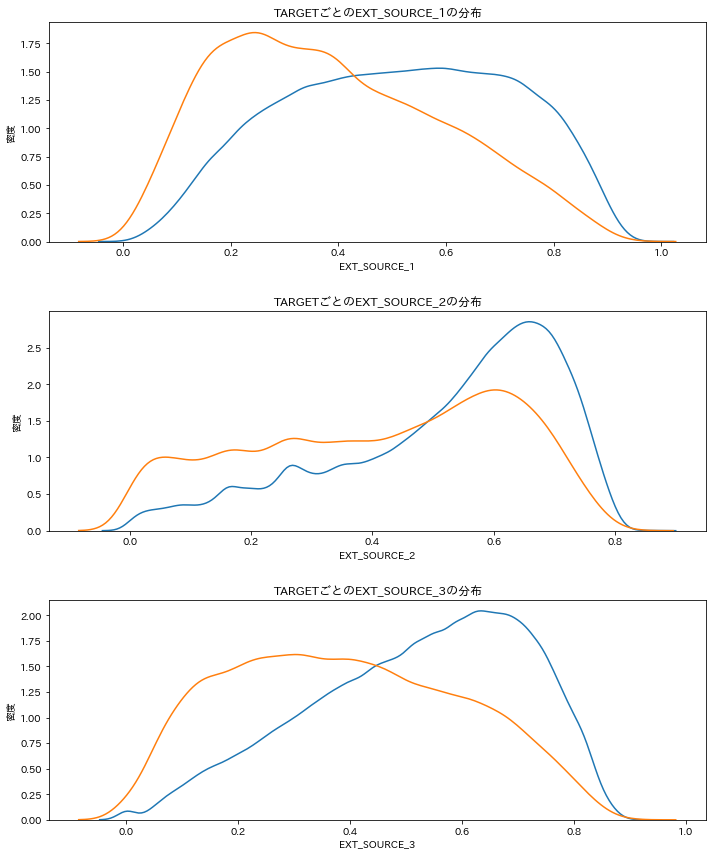

In [64]:
plt.figure(figsize=(10,12))

for i, data in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    plt.subplot(3, 1, i+1)
    sns.kdeplot(tmp_app_train.loc[tmp_app_train[TARGET] == 0, data], label = 'target == 0')
    sns.kdeplot(tmp_app_train.loc[tmp_app_train[TARGET] == 1, data], label = 'target == 1')

    # ラベルづけ
    plt.title(f'TARGETごとの{data}の分布')
    plt.xlabel('%s' % data); plt.ylabel('密度');

plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 がTarget =={0|1}の差が大きくなっているのでやはり重要なのがわかります。\
なので、`EXT_SOURCE_3 * EXT_SOURCE_3` で別のカラムを作成してみます

In [65]:
tmp_app_train['EXT_SOURCE_3*3'] = tmp_app_train['EXT_SOURCE_3'] * tmp_app_train['EXT_SOURCE_3']
tmp_app_test['EXT_SOURCE_3*3'] = tmp_app_test['EXT_SOURCE_3'] * tmp_app_test['EXT_SOURCE_3']

AMT_ 関連は非常に多く、また重要と見なされている特徴量があるので、これらを組み合わせて新たな特徴量を作ることが良さそうです。\
AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, AMT_PAYMENT etc..

In [66]:
column_desc[column_desc['Row'].str.contains('AMT_')]

,Unnamed: 0,Table,Row,Description,Special
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
10,13,application_{train|test}.csv,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,NaN
116,119,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_HOUR,Number of enquiries to Credit Bureau about the client one hour before application,NaN
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application),NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application),NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application),NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application),NaN
121,124,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_YEAR,Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application),NaN


In [67]:
# 全ての要素間の散布図（時間がかかるため、pairplot自体はコメントアウトしています）
tmp_amt = tmp_app_train.filter(like='AMT_', axis=1)
tmp_amt = pd.concat([tmp_app_train.iloc[:,1], tmp_amt], axis=1)
# sns.pairplot(tmp_amt, hue = TARGET)

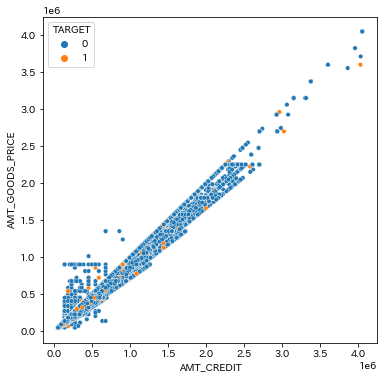

In [68]:
# AMT_GOODS_PRICE = 融資対象の商品価格
# AMT_CREDIT = 融資額
plt.figure(figsize=(6,6))
sns.scatterplot(x='AMT_CREDIT', y='AMT_GOODS_PRICE', hue=TARGET, s=20, data=tmp_app_train)
plt.show()

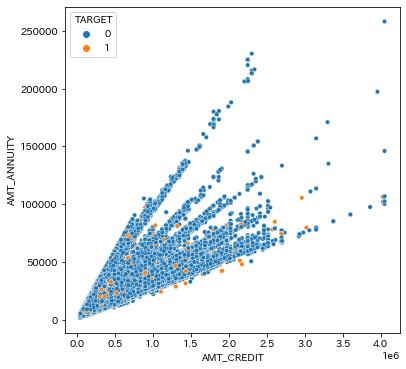

In [69]:
# AMT_ANNUITY = 年ごとのローン返済額？
# AMT_CREDIT = 融資額
plt.figure(figsize=(6,6))
sns.scatterplot(x='AMT_CREDIT', y='AMT_ANNUITY', hue=TARGET, s=20, data=tmp_app_train)
plt.show()

AMT_ 系のカラムで特徴量生成します

In [70]:
tmp_app_train['credit_goodsprice_diff'] = tmp_app_train['AMT_GOODS_PRICE'] - tmp_app_train['AMT_CREDIT']
tmp_app_test['credit_goodsprice_diff'] = tmp_app_test['AMT_GOODS_PRICE'] - tmp_app_test['AMT_CREDIT']

tmp_app_train['credit_goodsprice_ratio'] = tmp_app_train['AMT_CREDIT'] / tmp_app_train['AMT_GOODS_PRICE']
tmp_app_test['credit_goodsprice_ratio'] = tmp_app_test['AMT_CREDIT'] / tmp_app_test['AMT_GOODS_PRICE']


tmp_app_train['credit_annuity_ratio'] = tmp_app_train['AMT_CREDIT'] / tmp_app_train['AMT_ANNUITY']
tmp_app_test['credit_annuity_ratio'] = tmp_app_test['AMT_CREDIT'] / tmp_app_test['AMT_ANNUITY']

日数?データについてみてみます

app_{train|test}の `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_REGISTRATION`, `DAYS_ID_PUBLISH` あたりは日付表記ではないです。\
外れ値や異常値がないか確認した上(describe関数など使用して)で `DAYS_` を `YEARS_` などに直してみます。\
また `TARGET` との関係性も同時に見ていきます

In [71]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0000,-2120,NaN,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,Cash loans,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188,-1186.0000,-291,NaN,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6222,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.5559,0.

In [72]:
# DAYS_BIRTH -> YEAR_BIRTH に変換して見てみます
# 年齢に異常はなさそう
(app_train['DAYS_BIRTH'] / -365).describe()

count   307511.0000
mean        43.9370
std         11.9561
min         20.5178
25%         34.0082
50%         43.1507
75%         53.9233
max         69.1205
Name: DAYS_BIRTH, dtype: float64

Text(0, 0.5, 'count')

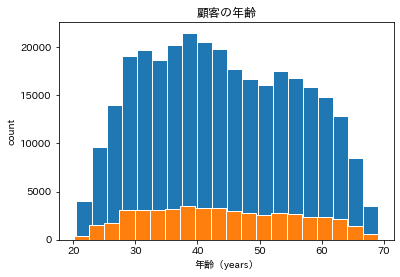

In [73]:
# `DAYS_BIRTH` をplotしてみます
## app_train
plt.hist(app_train['DAYS_BIRTH'] / -365, edgecolor = 'w', bins=20)
## app_test
plt.hist(app_test['DAYS_BIRTH'] / -365, edgecolor = 'w', bins=20)
plt.title('顧客の年齢'); plt.xlabel('年齢（years）'); plt.ylabel('count')

上記のplotだとあまり参考になる情報は多くないので、`TARGET` との関連性を踏まえた上で可視化してみます。\
以下ではKDE(Kernel Density Estimation)を使用した可視化をしていきます

[KDEとは](https://vaaaaaanquish.hatenablog.com/entry/2017/10/29/181949)

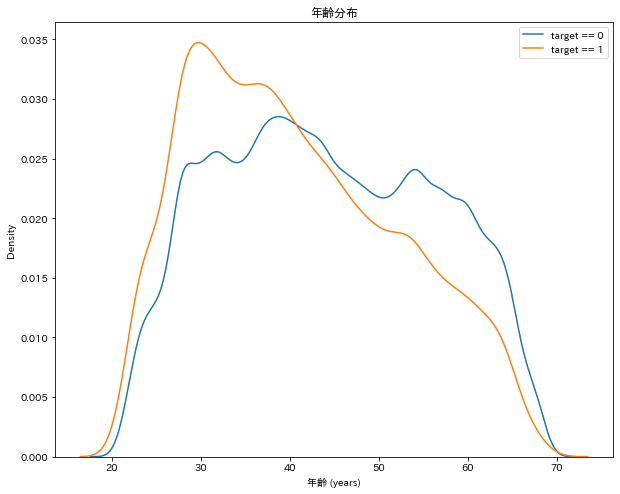

In [74]:
plt.figure(figsize = (10, 8))

# 約束通りにローン返済した人
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label='target == 0')

# 約束通りにローン返済しなかった人
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label='target == 1')

# ラベル
plt.xlabel('年齢 (years)'); plt.ylabel('Density'); plt.title('年齢分布'); plt.legend(loc='upper right')

In [75]:
# DAYS_EMPLOYED -> YEAR_EMPLOYED　に変換して見てみます
# min が-1000年と異常
(app_train['DAYS_EMPLOYED'] / -365).describe()

count   307511.0000
mean      -174.8357
std        387.0569
min      -1000.6658
25%          0.7918
50%          3.3233
75%          7.5616
max         49.0740
Name: DAYS_EMPLOYED, dtype: float64

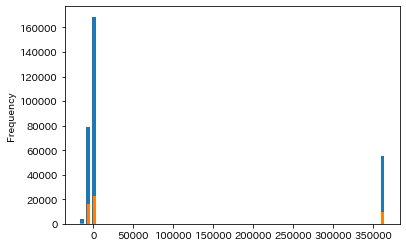

In [76]:
# `DAYS_EMPLOYED`　には異常値?が相当数あります
app_train['DAYS_EMPLOYED'].plot.hist(bins=50, rwidth=0.6);
app_test['DAYS_EMPLOYED'].plot.hist(bins=50, rwidth=0.6);

In [77]:
# 異常値はみんな同じ 　`365243`　で 合計55374個あるそうです。
display(app_train[app_train['DAYS_EMPLOYED'] > 35000]['DAYS_EMPLOYED'].count())

print('trainデータのdays_employed', app_train[app_train['DAYS_EMPLOYED'] > 35000]['DAYS_EMPLOYED'])

display(app_train[app_train['DAYS_EMPLOYED'] == 365243]['DAYS_EMPLOYED'].count())


print('testデータのdays_employed', app_test[app_test['DAYS_EMPLOYED'] > 35000]['DAYS_EMPLOYED'])

55374

trainデータのdays_employed 8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64


55374

testデータのdays_employed 10       365243
17       365243
22       365243
26       365243
36       365243
          ...  
48717    365243
48728    365243
48731    365243
48735    365243
48736    365243
Name: DAYS_EMPLOYED, Length: 9274, dtype: int64


どういう特徴をしているか確認してみます

In [78]:
# `DAYS_EMPLOYED`に異常値がないユーザーのローンデフォルト率の方が若干デフォルト率低いです。何故だかは不明。
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('`DAYS_EMPLOYED`が異常値であるユーザーのローンデフォルト率: %0.2f%%' % (100 * anom['TARGET'].mean()))
print('`DAYS_EMPLOYED`が異常値がないユーザーのローンデフォルト率: %0.2f%%' % (100 * non_anom['TARGET'].mean()))

`DAYS_EMPLOYED`が異常値であるユーザーのローンデフォルト率: 5.40%
`DAYS_EMPLOYED`が異常値がないユーザーのローンデフォルト率: 8.66%


異常値であるユーザーに異常値フラグの特徴量を追加し、365243を欠損値にします

In [79]:
# 異常値フラグを追加
tmp_app_train['DAYS_EMPLOYED_ANOM'] = np.where((tmp_app_train['DAYS_EMPLOYED'] == 365243), 1, 0)
tmp_app_test['DAYS_EMPLOYED_ANOM'] = np.where((tmp_app_test['DAYS_EMPLOYED'] == 365243), 1, 0)

# 欠損値に変換
tmp_app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
tmp_app_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

`DAYS_REGISTRATION` はあまり問題なさそうです

In [80]:
(app_train['DAYS_REGISTRATION'] / -365).describe()

count   307511.0000
mean        13.6606
std          9.6517
min         -0.0000
25%          5.5068
50%         12.3397
75%         20.4918
max         67.5945
Name: DAYS_REGISTRATION, dtype: float64

### bureauに関してもみていきます

In [81]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0000,-153.0000,NaN,0,91323.0000,0.0000,NaN,0.0000,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0000,NaN,NaN,0,225000.0000,171342.0000,NaN,0.0000,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0000,NaN,NaN,0,464323.5000,NaN,NaN,0.0000,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0000,NaN,NaN,0.0000,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0000,NaN,77674.5000,0,2700000.0000,NaN,NaN,0.0000,Consumer credit,-21,NaN


In [82]:
bureau_balance[bureau_balance[SK_ID_BUREAU] == 5715448].head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [83]:
# 申請の何日前に信用審査をしたのか
(bureau['DAYS_CREDIT']/ -1).describe()

count   1716428.0000
mean       1142.1077
std         795.1649
min          -0.0000
25%         474.0000
50%         987.0000
75%        1666.0000
max        2922.0000
Name: DAYS_CREDIT, dtype: float64

Text(0, 0.5, 'count')

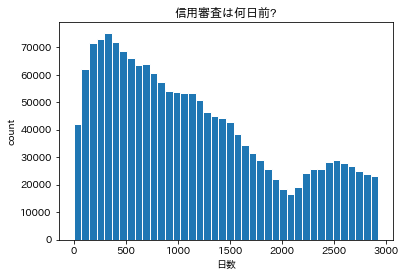

In [84]:
# `DAYS_CREDIT` を plotしてみます
plt.hist(bureau['DAYS_CREDIT'] / -1, edgecolor = 'w', bins=40)
plt.title('信用審査は何日前?'); plt.xlabel('日数'); plt.ylabel('count')

In [85]:
bureau['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

bureau の `SK_ID_BUREAU` は全てユニークです

In [86]:
print(f'Size of bureau_balance: {bureau.shape}')
bureau['SK_ID_BUREAU'].nunique()

Size of bureau_balance: (1716428, 17)


1716428

In [87]:
# Active　と Close で分類してみます
bu_active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
bu_close = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']

In [88]:
bu_active = bu_active[[SK_ID_CURR, 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']].groupby(by=SK_ID_CURR, as_index=False).agg('mean')

# ID＿CURRは分けます
bu_active_id = bu_active[SK_ID_CURR]
# SK_ID_CURRの他に不必要なカラム2つを除去します
bu_active = bu_active.drop(SK_ID_CURR, axis=1)

# 接頭辞をつけます
bu_active = bu_active.add_prefix('bureau_active_')

# 結合させます
bu_active = pd.concat([bu_active_id, bu_active], axis=1)
bu_active

,SK_ID_CURR,bureau_active_DAYS_CREDIT,bureau_active_CREDIT_DAY_OVERDUE,bureau_active_DAYS_CREDIT_ENDDATE,bureau_active_DAYS_ENDDATE_FACT,bureau_active_AMT_CREDIT_MAX_OVERDUE,bureau_active_CNT_CREDIT_PROLONG,bureau_active_AMT_CREDIT_SUM,bureau_active_AMT_CREDIT_SUM_DEBT,bureau_active_AMT_CREDIT_SUM_LIMIT,bureau_active_AMT_CREDIT_SUM_OVERDUE,bureau_active_DAYS_CREDIT_UPDATE,bureau_active_AMT_ANNUITY
0,100001,-309.3333,0.0000,1030.3333,NaN,NaN,0.0000,294675.0000,198895.5000,0.0000,0.0000,-10.6667,8272.5000
1,100002,-572.5000,0.0000,780.0000,NaN,40.5000,0.0000,240994.2825,122890.5000,15994.2825,0.0000,-15.5000,0.0000
2,100003,-606.0000,0.0000,1216.0000,NaN,0.0000,0.0000,810000.0000,0.0000,810000.0000,0.0000,-43.0000,NaN
3,100005,-99.5000,0.0000,723.0000,NaN,0.0000,0.0000,299313.0000,284204.2500,0.0000,0.0000,-21.0000,2130.7500
4,100008,-78.0000,0.0000,471.0000,NaN,0.0000,0.0000,267606.0000,240057.0000,0.0000,0.0000,-16.0000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251810,456247,-453.6667,0.0000,7462.3333,NaN,12462.7500,0.0000,1371000.0000,1096695.0000,0.0000,0.0000,-24.0000,2164.5000
251811,456249,-1547.5000,0.0000,-67.0000,-1318.0000,0.0000,0.0000,202500.0000,81535.5000,0.0000,0.0000,-612.5000,NaN
251812,456250,-792.0000,0.0000,2068.5000,NaN,0.0000,0.0000,1301555.0250,1116020.0475,29134.1925,0.0000,-27.0000,39778.4475
251813,456253,-816.0000,0.0000,750.0000,NaN,NaN,0.0000,1305000.0000,897916.5000,0.0000,0.0000,-92.0000,58369.5000


ついでに `SK_ID_CURR`　でgroupbyした中で Closeでの平均も出してみます

In [89]:
# Closeの特徴量の平均を取得して、追加します
bu_close = bu_close[[SK_ID_CURR, 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']].groupby(by=SK_ID_CURR, as_index=False).agg('mean')

# SK_ID_CURRに接頭辞をつけないように一旦分けます
bu_close_id = bu_close[SK_ID_CURR]
bu_close = bu_close.drop(SK_ID_CURR, axis=1)

bu_close = bu_close.add_prefix('bureau_close_mean_')

In [90]:
bu_close = pd.concat([bu_close_id, bu_close], axis=1)
bu_close

,SK_ID_CURR,bureau_close_mean_DAYS_CREDIT,bureau_close_mean_CREDIT_DAY_OVERDUE,bureau_close_mean_DAYS_CREDIT_ENDDATE,bureau_close_mean_DAYS_ENDDATE_FACT,bureau_close_mean_AMT_CREDIT_MAX_OVERDUE,bureau_close_mean_CNT_CREDIT_PROLONG,bureau_close_mean_AMT_CREDIT_SUM,bureau_close_mean_AMT_CREDIT_SUM_DEBT,bureau_close_mean_AMT_CREDIT_SUM_LIMIT,bureau_close_mean_AMT_CREDIT_SUM_OVERDUE,bureau_close_mean_DAYS_CREDIT_UPDATE,bureau_close_mean_AMT_ANNUITY
0,100001,-1054.2500,0.0000,-628.5000,-825.5000,NaN,0.0000,142335.0000,0.0000,0.0000,0.0000,-155.0000,0.0000
1,100002,-974.5000,0.0000,-574.8000,-697.5000,2091.1613,0.0000,63844.5000,0.0000,0.0000,0.0000,-661.3333,0.0000
2,100003,-1665.6667,0.0000,-1131.3333,-1097.3333,0.0000,0.0000,69133.5000,0.0000,0.0000,0.0000,-1073.6667,NaN
3,100004,-867.0000,0.0000,-488.5000,-532.5000,0.0000,0.0000,94518.9000,0.0000,0.0000,0.0000,-532.0000,NaN
4,100005,-373.0000,0.0000,-128.0000,-123.0000,NaN,0.0000,58500.0000,0.0000,0.0000,0.0000,-121.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267920,456249,-1688.8182,0.0000,-1465.4000,-1369.0000,7683.7500,0.0000,298987.1509,0.0000,0.0000,0.0000,-1146.7273,NaN
267921,456250,-1002.0000,0.0000,-272.0000,-760.0000,NaN,0.0000,483349.5000,0.0000,0.0000,0.0000,-127.0000,384147.0000
267922,456253,-919.0000,0.0000,-189.0000,-794.0000,NaN,0.0000,675000.0000,0.0000,0.0000,0.0000,-414.5000,58369.5000
267923,456254,-1104.0000,0.0000,-859.0000,-859.0000,NaN,0.0000,45000.0000,0.0000,NaN,0.0000,-401.0000,0.0000


In [91]:
# bu_activeと bu_closeをマージさせます
bu_both = pd.merge(bu_active, bu_close, on=SK_ID_CURR, how='outer')
bu_both

,SK_ID_CURR,bureau_active_DAYS_CREDIT,bureau_active_CREDIT_DAY_OVERDUE,bureau_active_DAYS_CREDIT_ENDDATE,bureau_active_DAYS_ENDDATE_FACT,bureau_active_AMT_CREDIT_MAX_OVERDUE,bureau_active_CNT_CREDIT_PROLONG,bureau_active_AMT_CREDIT_SUM,bureau_active_AMT_CREDIT_SUM_DEBT,bureau_active_AMT_CREDIT_SUM_LIMIT,bureau_active_AMT_CREDIT_SUM_OVERDUE,bureau_active_DAYS_CREDIT_UPDATE,bureau_active_AMT_ANNUITY,bureau_close_mean_DAYS_CREDIT,bureau_close_mean_CREDIT_DAY_OVERDUE,bureau_close_mean_DAYS_CREDIT_ENDDATE,bureau_close_mean_DAYS_ENDDATE_FACT,bureau_close_mean_AMT_CREDIT_MAX_OVERDUE,bureau_close_mean_CNT_CREDIT_PROLONG,bureau_close_mean_AMT_CREDIT_SUM,bureau_close_mean_AMT_CREDIT_SUM_DEBT,bureau_close_mean_AMT_CREDIT_SUM_LIMIT,bureau_close_mean_AMT_CREDIT_SUM_OVERDUE,bureau_close_mean_DAYS_CREDIT_UPDATE,bureau_close_mean_AMT_ANNUITY
0,100001,-309.3333,0.0000,1030.3333,NaN,NaN,0.0000,294675.0000,198895.5000,0.0000,0.0000,-10.6667,8272.5000,-1054.2500,0.0000,-628.5000,-825.5000,NaN,0.0000,142335.0000,0.0000,0.0000,0.0000,-155.0000,0.0000
1,100002,-572.5000,0.0000,780.0000,NaN,40.5000,0.0000,240994.2825,122890.5000,15994.2825,0.0000,-15.5000,0.0000,-974.5000,0.0000,-574.8000,-697.5000,2091.1613,0.0000,63844.5000,0.0000,0.0000,0.0000,-661.3333,0.0000
2,100003,-606.0000,0.0000,1216.0000,NaN,0.0000,0.0000,810000.0000,0.0000,810000.0000,0.0000,-43.0000,NaN,-1665.6667,0.0000,-1131.3333,-1097.3333,0.0000,0.0000,69133.5000,0.0000,0.0000,0.0000,-1073.6667,NaN
3,100005,-99.5000,0.0000,723.0000,NaN,0.0000,0.0000,299313.0000,284204.2500,0.0000,0.0000,-21.0000,2130.7500,-373.0000,0.0000,-128.0000,-123.0000,NaN,0.0000,58500.0000,0.0000,0.0000,0.0000,-121.0000,0.0000
4,100008,-78.0000,0.0000,471.0000,NaN,0.0000,0.0000,267606.0000,240057.0000,0.0000,0.0000,-16.0000,NaN,-1097.0000,0.0000,-822.5000,-909.0000,NaN,0.0000,100419.7500,0.0000,0.0000,0.0000,-908.5000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305617,456185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1186.2000,0.0000,-851.0000,-838.6000,0.0000,0.0000,38799.4410,0.0000,0.0000,0.0000,-767.6000,NaN
305618,456191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1131.0000,0.0000,-836.6667,-842.3333,NaN,0.0000,117587.2200,0.0000,0.0000,0.0000,-491.6667,NaN
305619,456197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1326.2857,0.0000,-1048.0000,-1045.7143,0.0000,0.0000,57627.0000,0.0000,0.0000,0.0000,-982.1429,NaN
305620,456237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1430.0000,0.0000,-699.0000,-1090.0000,NaN,0.0000,98145.0000,0.0000,0.0000,0.0000,-1090.0000,NaN


In [92]:
## 再度、train と test にもマージします
train = pd.merge(tmp_app_train, tmp3, on=SK_ID_CURR, how='left')
test = pd.merge(tmp_app_test, tmp3, on=SK_ID_CURR, how='left')

In [93]:
# train test どちらにもマージさせます
train = pd.merge(train, bu_both, on=SK_ID_CURR, how='left')
test = pd.merge(test, bu_both, on=SK_ID_CURR, how='left')

予測対象となる `TARGET`カラムを抜き出し、 `y` とします

同時にtrainから `TARGET`カラムを削除します

In [94]:
y_train = train['TARGET']
X_train = train.drop('TARGET', axis=1)
X_test = test.copy()

# numpy 配列に直します
X, y = X_train.values, y_train.values
X_test2 = X_test.values

In [95]:
# X_trainとy_trainの行数が、X_train, X_testのカラム数がそれぞれ同数なのでOK
print(X.shape, y.shape, X_test2.shape)

(307511, 200) (307511,) (48744, 200)


In [96]:
# Stratified K Fold (層化抽出)を使用します
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=510)
cv = fold.split(X, y)
# split の返り値は generator だから、list 化して何度も iterate できるようにしておく
cv = list(cv)

モデル評価をします

In [97]:
oof, models =fit_lgbm(X=X, y=y, cv=cv, params=lgbm_params)

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.243699
[100]	valid_0's binary_logloss: 0.240686
[150]	valid_0's binary_logloss: 0.23951
[200]	valid_0's binary_logloss: 0.238962
[250]	valid_0's binary_logloss: 0.238821
[300]	valid_0's binary_logloss: 0.238894
[350]	valid_0's binary_logloss: 0.238771
[400]	valid_0's binary_logloss: 0.238878
fit fold=0 11.475[s]
0.7825


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.24478
[100]	valid_0's binary_logloss: 0.2421
[150]	valid_0's binary_logloss: 0.241305
[200]	valid_0's binary_logloss: 0.240839
[250]	valid_0's binary_logloss: 0.240407
[300]	valid_0's binary_logloss: 0.240333
[350]	valid_0's binary_logloss: 0.240475
fit fold=1 9.990[s]
0.7780


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.244968
[100]	valid_0's binary_logloss: 0.241914
[150]	valid_0's binary_logloss: 0.240752
[200]	valid_0's binary_logloss: 0.240334
[250]	valid_0's binary_logloss: 0.240093
[300]	valid_0's binary_logloss: 0.239843
[350]	valid_0's binary_logloss: 0.239909
[400]	valid_0's binary_logloss: 0.240175
fit fold=2 10.122[s]
0.7798


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.243424
[100]	valid_0's binary_logloss: 0.240218
[150]	valid_0's binary_logloss: 0.239071
[200]	valid_0's binary_logloss: 0.238594
[250]	valid_0's binary_logloss: 0.238328
[300]	valid_0's binary_logloss: 0.238175
[350]	valid_0's binary_logloss: 0.238271
fit fold=3 9.740[s]
0.7820


/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: colsample_samples
[50]	valid_0's binary_logloss: 0.24345
[100]	valid_0's binary_logloss: 0.240515
[150]	valid_0's binary_logloss: 0.239585
[200]	valid_0's binary_logloss: 0.239102
[250]	valid_0's binary_logloss: 0.238778
[300]	valid_0's binary_logloss: 0.238899
[350]	valid_0's binary_logloss: 0.238942
fit fold=4 9.812[s]
0.7833
0.7811


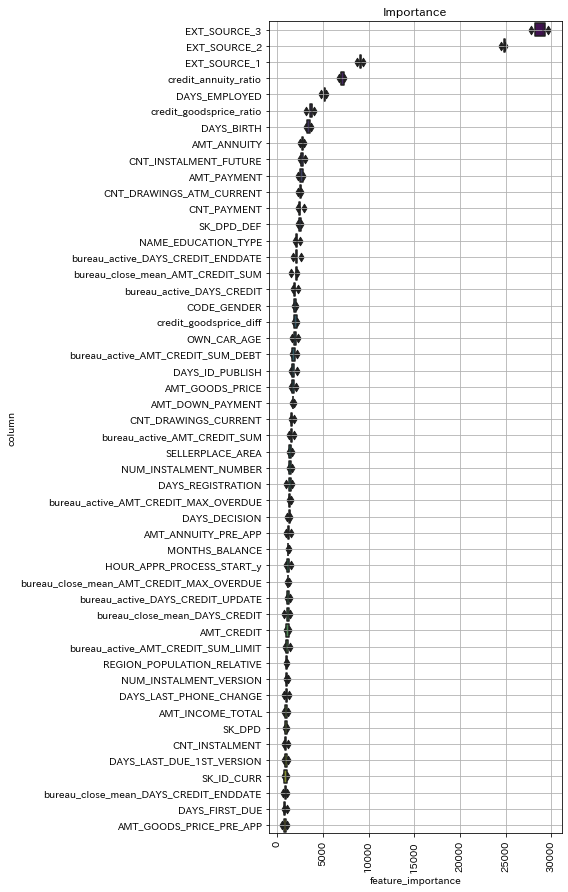

In [98]:
# 重要度の可視化
%matplotlib inline
fig, ax = visualize_importance(models, X_train)

訓練データとテストデータでの予測結果の傾向差を見る

In [99]:
# K 個のモデルの予測確率（predict_proba） を作成します。 shape = (k, N_test, n_classes) になるはずです。
pred_prob = np.array([model.predict_proba(X_test2) for model in models])
print(f"1. shape: {pred_prob.shape}")

# k 個のモデルの平均を計算
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れます
print(f"2. shape: {pred_prob.shape}")


# 欲しいのは y=1 の確率なので全要素の 1 次元目を取ってきます
pred_prob = pred_prob[:, 1]
print(f'3. shape: {pred_prob.shape}')

# ついでにsample_submissionのshapeとも比較しましょう
print('4. shape:', samp_sub.shape)

1. shape: (5, 48744, 2)
2. shape: (48744, 2)
3. shape: (48744,)
4. shape: (48744, 2)


In [100]:
pred_prob

array([0.0328, 0.1143, 0.0129, ..., 0.0107, 0.0336, 0.2205])

/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/satoshiido/miniforge3/envs/python38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


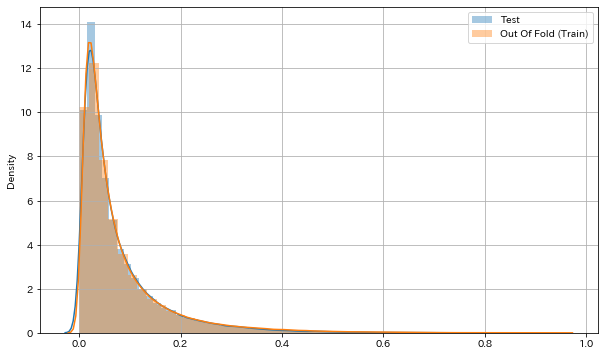

In [101]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(pred_prob, ax=ax, label="Test")
sns.distplot(oof, ax=ax, label="Out Of Fold (Train)")

ax.legend()
ax.grid()

サブミットファイルの作成を作成します\
sample_submissionのファイルを使って予測対象を抽出します

In [102]:
samp_sub3 = samp_sub.copy()
samp_sub3.TARGET = pred_prob
samp_sub3.head()

,SK_ID_CURR,TARGET
0,100001,0.0328
1,100005,0.1143
2,100013,0.0129
3,100028,0.0334
4,100038,0.1302


In [103]:
samp_sub3.to_csv(os.path.join(OUTPUT_DIR, 'baseline_#2_submission.csv'), index=False)

## モデル選択 & パラメーターチューニング

今回はここまで手が回りませんでした、、NNとか試したり、Optunaを試してみたかった。

追記で